This is a Python notebook showing the use of GooFit: Python and a simple double Gaussian. It requires a recent version of Python 3, since that allows nicer numbers and unicode (Greek) variable names.

First, we import NumPy and Matplotlib, which we will use to make the data and plot, respectively.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We should also import GooFit. This (obviously) requires that you have GooFit installed. If you don't, look at the installation instructions at <https://pypi.org/project/goofit/>. We will call the package `gf` for short.

In [2]:
import goofit as gf

Now, in order to fit some data, we need to generate some data. Let's make a double Gaussian dataset. We will set the seed (just so the example is exactly reproducible), and then we will generate from two Gaussian distributions and combine the samples by stacking them end to end. Since the order of the samples is not important, we won't bother to reshuffle them.

In [3]:
np.random.seed(42)           # The following numpy code is now deterministic

dist = np.hstack([           # Append a list of 1D numpy arrays into a 1D numpy array
    np.random.normal(loc=1, scale=2., size=500_000),
    np.random.normal(loc=1, scale=.5, size=500_000)
])

Now we need to define a model. The basic model is this:

$$
f_0 \, g(x; \mu, \sigma_1) + (1 - f_0) \, g(x; \mu, \sigma_2)
$$

Here, $x$ is an Observable, since it has a different value for each event, and the rest of the parameters are "Variables". We will provide limits for all of the values (Observables and Variables), and starting values for the Variables. If you are in a Jupyter notebook and using Python 3, you can use Greek names for Python variables by typing the LaTeX name then pressing tab. GooFit expects ASCII strings, so please leave those names non-Greek.

In [4]:
x = gf.Observable('x', -10, 10)

μ = gf.Variable('mu', 1.5, -10, 10)
σ_1 = gf.Variable('sigma_1', .4, 0, 1)
σ_2 = gf.Variable('sigma_2', 3, 1, 3)
f_0 = gf.Variable('f_0', .5, 0, 1)

Now, we need to define the PDFs. Each one will depend on x as the Observable, and the necessary variables. You can give a variable multiple times to indicate a shared variable, such as the $\mu$ below.

Adding PDFs is done using AddPdf, with two lists - the first is a list of N-1 fractions, and the second is a list of N components to add.

In [5]:
gauss_1 = gf.GaussianPdf("gauss1", x, μ, σ_1)
gauss_2 = gf.GaussianPdf("gauss2", x, μ, σ_2)

pdf = gf.AddPdf('pdf', [f_0], [gauss_1, gauss_2])

Now, we need to add data to a `BinnedDataSet` or `UnbinnedDataSet`. You need to tell the DataSet what Observable(s) it is associated to, and you need to add data using `.from_matrix`. This takes a 2D matrix, where the columns correspond to the observables. An easy way to input 1D NumPy arrays as matrices is to put them into a list, such as `[data_x, data_y]`. The optional `filter=True` will remove events that are not inside the Observable's limits, instead of raising an error.

Note that `camelCase` style method names are used for C++ GooFit methods, and `under_score` style names are used for Python-only methods.

In [6]:
ds = gf.UnbinnedDataSet(x)
ds.from_matrix([dist], filter=True)

Now, we can do our fit! We will use the RooFit style `.fitTo` on the PDF, with the dataset we want to fit to.

In [7]:
pdf.fitTo(ds);

MnSeedGenerator: for initial parameters FCN = 3874835.510744
MnSeedGenerator: Initial state:   - FCN =   3874835.510744 Edm =       744932 NCalls =     19
MnSeedGenerator: Negative G2 found - new state:   - FCN =   3735439.992451 Edm =       712480 NCalls =     44
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   3735439.992451 Edm =       712480 NCalls =     44
VariableMetric: Iteration #   0 - FCN =   3735439.992451 Edm =       712480 NCalls =     44
VariableMetric: Iteration #   1 - FCN =   3365672.046863 Edm =      20560.4 NCalls =     56
VariableMetric: Iteration #   2 - FCN =   3351286.808871 Edm =      3712.53 NCalls =     66
VariableMetric: Iteration #   3 - FCN =    3346224.03184 Edm =      290.217 NCalls =     76
VariableMetric: Iteration #   4 - FCN =   3345976.094262 Edm =      22.4637 NCalls =     86
VariableMetric: Iteration #   5 - FCN =   3345892.605172 Edm =       3.8225 NCalls =     96
VariableMetric: Iteration #   6 - FCN

All the parameters now have the values from the fit:

In [8]:
f_0.value

0.4990089500342974

Now, we need to evaluate the PDF over a grid, so we can make a plot. We can use `pdf.evaluatePdf(var)` to evaluate a pdf over a variable. The `numbins` property of the Observable will be used in the evaluation to create the grid. The return values will be an UnbinnedDataSet with the grid of x values, and the y values as a list. You probably want to use `.to_matrix()` to convert to a matrix (and maybe flatten in from a $(1\times \mathrm{numbins})$ matrix to a 1D array). The x values are the bin centers where y values were evaluated at.

In [9]:
x.numbins = 1000
grid, points = pdf.evaluatePdf(x)
xs = grid.to_matrix().flatten()

As long as we are at it, why not evaluate the components, too?

In [10]:
grid_1, points_1 = gauss_1.evaluatePdf(x)
xs_1 = grid_1.to_matrix().flatten()
points_1 = np.asarray(points_1)

grid_2, points_2 = gauss_2.evaluatePdf(x)
xs_2 = grid_2.to_matrix().flatten()
points_2 = np.asarray(points_2)

Since these are normalized, we will need to use our factor definition to plot them to scale with the original pdf.

Now, we can plot the evaluated function along with a standard histogram. We'll use a normalized histogram plot (`density=True`) to plot the histogram.

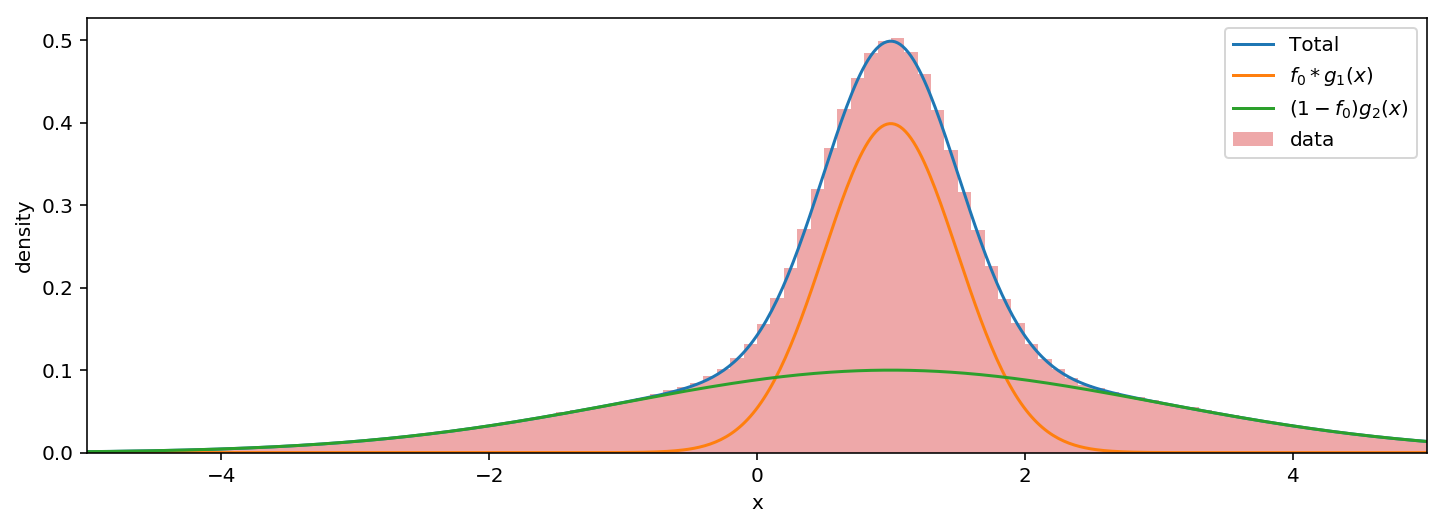

In [11]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(xs, points, label='Total')
ax.plot(xs_1, points_1 * f_0.value, label='$f_0 * g_1(x)$')
ax.plot(xs_2, points_2 * (1 - f_0.value), label='$(1 - f_0 ) g_2(x)$')
ax.hist(dist, bins=100, range=(-5,5), density=True, alpha=.4, label='data')
ax.set_xlim(-5,5)
ax.set_xlabel('x')
ax.set_ylabel('density')
plt.legend()
plt.show()